In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import scipy as sp
import seaborn as sns
%load_ext watermark
%watermark
%watermark -p scipy

2018-06-18T15:05:53+02:00

CPython 3.6.5
IPython 6.4.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.4.132-53-default
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
scipy 1.1.0


In [2]:
import c14_models

# Atmospheric C14 function

In [3]:
C_atm = c14_models.C_atm

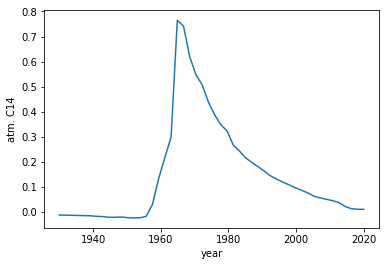

In [4]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(C_atm)(tt))

plt.xlabel('year')
plt.ylabel('atm. C14')

plt.show()

# Scenario I1_d1

I stands for inheritence. Half of the DNA is inherited from the mother to the daughter.
1 stands for 1 population.
d1 stands for single daughter assumption.

## Discretization of master equation

In [7]:
@numba.njit
def f(t, C):
    return 0.5 * (C + C_atm(t))

@numba.njit
def find_nearest(C, CC):
    dC = (CC[1] - CC[0])/ (CC[-1] - CC[0]) 
    i = np.rint((C - CC[0])/ (CC[-1] - CC[0]) /dC)
    i = i.astype(np.int16)
    return i

@numba.njit
def k(t, CC, C):
    return find_nearest(f(t, C), CC)

@numba.njit
def kCC(t, CC):
    return k(t, CC, CC)

@numba.njit
def target_matrix(t, CC):
    n = len(CC)
    T = np.zeros((n, n))
    k = kCC(t, CC)
    for j, i in enumerate(k):
        T[i, j] = 1.0
    return T

@numba.njit
def rate_matrix(t, CC):
    T = target_matrix(t, CC)
    A = T - np.eye(len(CC))
    return A

@numba.njit
def rhs(N, t0, CC, r):
    A = rate_matrix(t0, CC)
    dNdt = r * A @ N
    return dNdt

@numba.jit
def I1_d1a(Dbirth, Dcoll, r, n=3, dt = 0.1):
    C_min = -0.024899999999999999
    C_max = 0.8357
    
    CC = np.linspace(C_min, C_max, n)
    
    N0 = np.zeros(n)
    N0[find_nearest(np.array([C_atm(Dbirth)]), CC)] = 1
    
    t= (Dbirth, Dcoll)
    sol = sp.integrate.odeint(rhs, N0, t, args=(CC, r), mxstep=int(1e5))
    N = sol[-1]
    C = np.average(CC, weights=N)
    return C

## Gillespie

In [8]:
@numba.njit
def C_L1_cell(Dbirth, Dcoll, r, C_init=np.inf):
    t = Dbirth
    
    if C_init==np.inf:
        C_init = C_atm(t)
    c = C_init
    
    while True:
        t += np.random.exponential(1/r)
        if t > Dcoll:
            break
        else:
            c = 0.5 * (c + C_atm(t))
    return c

@numba.njit
def I1_d1b(Dbirth, Dcoll, r, N=1000, C_init=np.inf):
    cc = np.array([C_L1_cell(Dbirth, Dcoll, r, C_init) for i in range(N)])
    return cc.mean()

## ODE

You get this ODE by calculating the first moment of the master equation.

In [9]:
None==None

True

In [10]:
def I1_d1(Dbirth, Dcoll, r, C_init=np.inf, t_eval=None):
    if C_init==np.inf:
        C_init = C_atm(Dbirth)
        
    if t_eval==None:
        t_eval = [Dcoll]

    def rhs(t, c, r):
        return 0.5 * r * (C_atm(t) - c)
    def Dfun(c, t0, r):
        return -0.5 * r
    C = sp.integrate.solve_ivp(fun=lambda t, c: rhs(t, c, r=r),
                               t_span=[Dbirth, Dcoll],
                               y0=[C_init], 
                               t_eval=t_eval)['y'][0, 0]
    return C

## Compare

Same results:

In [11]:
print(I1_d1a(1930, 2015, 0.1, n=30))
print(I1_d1b(1930, 2015, 0.1, 1000))
print(I1_d1(1930, 2015, 0.1))

0.124877724311
0.12799945929952916
0.125491263298


Performance:

# Scenario I1

I stands for inheritence. Half of the DNA is inherited from the mother to the daughter.
1 stands for 1 population.
Here, the more realistic 2 daughter assumption is used.

## Gillespie

In [8]:
I1a = c14_models.I1a

## Empirical ODE

In [9]:
I1 = c14_models.I1

## Analytical solution of ODE

In [10]:
I1c = c14_models.I1c

## Compare

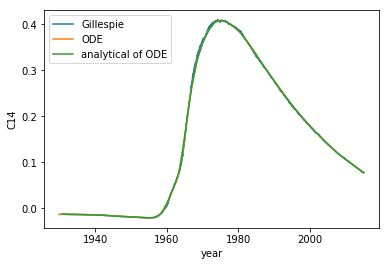

In [15]:
lam = 0.1

np.random.seed(42)
plt.plot(*I1a(1930, 2015, lam, lam, N=1000), label='Gillespie')
plt.plot(*I1(1930, 2015, lam, t_eval=np.linspace(1930, 2015)), 
         label='ODE')

tt = np.linspace(1931, 2015)
plt.plot(tt, np.vectorize(I1c)(1930, tt, lam), 
         label='analytical of ODE')

plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

# I1 memory

In [24]:
@np.vectorize
def I1_memory(Dbirth, Dcoll, loglam, f, t0):
    lam = np.exp(loglam)
    C1 = c14_models.I1c(Dbirth, Dcoll, lam)
    
    if t0>Dcoll-Dbirth:
        return C1
    else:
        C0 = c14_models.I1c(Dbirth, Dbirth + t0, lam)
        return f*C1 + (1-f)*C0

## Compare

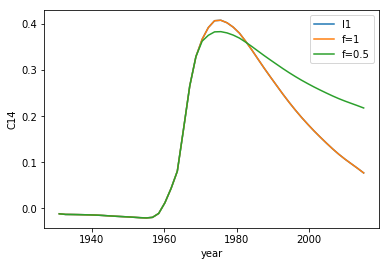

In [28]:
lam = 0.1

np.random.seed(42)

tt = np.linspace(1931, 2015)
plt.plot(tt, np.vectorize(I1c)(1930, tt, lam), 
         label='I1')

plt.plot(tt, np.vectorize(I1_memory)(1930, tt, np.log(lam), 1.0, 40.0), label='f=1')
plt.plot(tt, np.vectorize(I1_memory)(1930, tt, np.log(lam), 0.5, 40.0), label='f=0.5')

plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

# Scenario I1C

C... division rate depends on subject's age

## ODE

In [15]:
def I1C(Dbirth, Dcoll, r0, r1, C_init=np.inf, timing=False):
    if C_init==np.inf:
        C_init = C_atm(Dbirth)
    
    def r(t, r0, r1):
         return r0 * np.exp(-r1 * (t-Dbirth))
    
    def rhs(t, c, r0, r1):
        return r(t, r0, r1) * (C_atm(t) - c)
    
    if timing:
        t_eval = np.linspace(Dbirth, Dcoll, 100)
    else:
        t_eval = [Dcoll]
#     CC = sp.integrate.odeint(rhs, C_init, tt, args = (r, ), Dfun = Dfun)[:, 0]
    
    C = sp.integrate.solve_ivp(fun=lambda t, c: rhs(t, c, r0=r0, r1=r1),
                               t_span=[Dbirth, Dcoll],
                               y0=[C_init], 
                               t_eval=t_eval)
    
    if timing:
        return C['t'], C['y'][0]
    else:
        return C['y'][0, 0]

## Compare

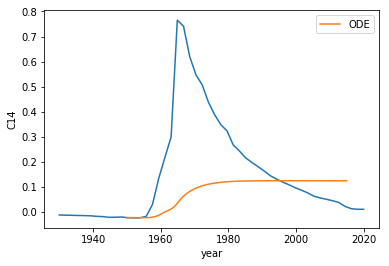

In [16]:
plt.plot(tt, np.vectorize(C_atm)(tt))
plt.plot(*I1C(1950, 2015, 0.1, 1e-1, timing=True), label='ODE')

plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

# Scenario I1E

E...Age-dependent death rate

## Time-discrete implementation

In [17]:
@numba.njit
def k(a, g0, g1):
    return g0 * g1 / (g1 + a)

@numba.njit
def I1Ea(Dbirth, Dcoll, g0, g1, C_init=np.inf, N=1000, dt=0.1):
    t = Dbirth
    
    if C_init==np.inf:
        C_init = C_atm(t)
    cc = C_init * np.ones(N)
    aa = np.zeros(N)
    
    tt = np.arange(Dbirth, Dcoll, dt)
    cc_mean = np.empty_like(tt)
    
    for i, t in enumerate(tt):
        pp = k(aa, g0, g1) * dt
        
        die = np.random.rand(N) < pp
        die_ind = np.where(die)[0]
        
        div_ind = np.random.choice(np.where(~die)[0], size=len(die_ind), replace=False)
        
        cc_new = 0.5 * (cc[div_ind] + C_atm(t))
        
        cc[div_ind] = cc_new
        aa[div_ind] = 0.0
        
        cc[die_ind] = cc_new
        aa[die_ind] = 0.0
        
        cc_mean[i] = cc.mean()
        
        aa += dt
    return aa, tt, cc_mean

## ODE

In [18]:
a, *_ = 1, 2, 3

In [19]:
def I1E(Dbirth, Dcoll, g0, g1, C_init=np.inf, t_eval=None):
    if t_eval is None:
        t_eval = [Dcoll]
    if C_init==np.inf:
        C_init = C_atm(Dbirth)
        
    # in the future get analytic expression to calculate steady state age distribution 
    aa, *_ = I1Ea(Dbirth, Dcoll, g0, g1, N=1000, dt=0.001)    
    r1 = k(aa, g0, g1).mean()
    
    tt_I1, CC_I1 = I1(Dbirth, Dcoll, r1, t_eval=t_eval)
    
    return tt_I1, CC_I1

## Compare

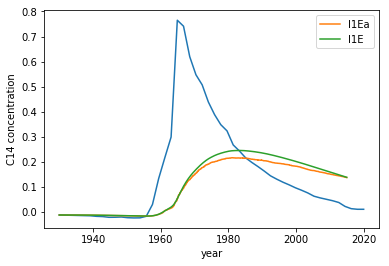

In [20]:
np.random.seed(42)
g0 = 0.1
g1 = 5.0

tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(C_atm)(tt))

np.random.seed(42)
aa_I1E, tt_I1E, CC_I1Ea = I1Ea(1930, 2015, g0, g1, N=1000, dt=0.001)
plt.plot(tt_I1E, CC_I1Ea, label = 'I1Ea')

plt.plot(*I1E(1930, 2015, g0, g1, t_eval=tt_I1E), label = 'I1E')



plt.xlabel('year')
plt.ylabel('C14 concentration')
plt.legend()

plt.show()

In [21]:
Dbirth = 1930
Dcoll = 2015
g0 = 0.1
g1 = 5.0
aa_I1E, tt_I1E, CC_I1Ea = I1Ea(1930, 2015, g0, g1, N=1000, dt=0.001)

In [22]:
def func(lam):
     return np.sum((I1(Dbirth, Dcoll, lam, t_eval=tt_I1E)[1] - CC_I1Ea)**2)

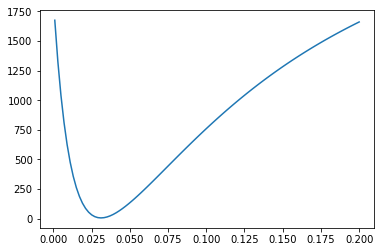

In [23]:
x = np.linspace(0.001, 0.2, 100)
plt.plot(x, np.vectorize(func)(x))

In [24]:
lam = sp.optimize.minimize(func, 0.05, method='Nelder-Mead')['x']
lam

array([ 0.03117188])

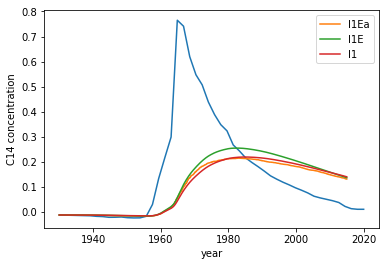

In [25]:
np.random.seed(42)
g0 = 0.1
g1 = 5.0

tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(C_atm)(tt))

np.random.seed(42)
plt.plot(tt_I1E, CC_I1Ea, label = 'I1Ea')

plt.plot(*I1E(1930, 2015, g0, g1, t_eval=tt_I1E), label = 'I1E')

plt.plot(*I1(1930, 2015, lam, t_eval=tt_I1E), label = 'I1')

plt.xlabel('year')
plt.ylabel('C14 concentration')
plt.legend()

plt.show()

# Scenario I1F

E...Age-dependent proliferation rate

## Time-discrete implementation

In [26]:
@numba.njit
def k(a, g0, g1):
    return g0 * g1 / (g1 + a)

@numba.njit
def I1Fa(Dbirth, Dcoll, g0, g1, C_init=np.inf, N=1000, dt=0.1):
    t = Dbirth
    
    if C_init==np.inf:
        C_init = C_atm(t)
    cc = C_init * np.ones(N)
    aa = np.zeros(N)
    
    tt = np.arange(Dbirth, Dcoll, dt)
    cc_mean = np.empty_like(tt)
    
    for i, t in enumerate(tt):
        pp = k(aa, g0, g1) * dt
        
        div = np.random.rand(N) < pp
        div_ind = np.where(div)[0]
        
        die_ind = np.random.choice(np.where(~div)[0], size=len(div_ind), replace=False)
        
        cc_new = 0.5 * (cc[div_ind] + C_atm(t))
        
        cc[div_ind] = cc_new
        aa[div_ind] = 0.0
        
        cc[die_ind] = cc_new
        aa[die_ind] = 0.0
        
        cc_mean[i] = cc.mean()
        
        aa += dt
    return aa, tt, cc_mean

## ODE

In [27]:
def I1F(Dbirth, Dcoll, g0, g1, C_init=np.inf, t_eval=None):
    if t_eval is None:
        t_eval = [Dcoll]
    if C_init==np.inf:
        C_init = C_atm(Dbirth)
        
    # in the future get analytic expression to calculate steady state age distribution 
    aa, tt_LD, CC_LD = I1Fa(Dbirth, Dcoll, g0, g1, N=1000, dt=0.001)    
    r1 = k(aa, g0, g1).mean()
    
    tt_I1, CC_I1 = I1(Dbirth, Dcoll, r1, t_eval=t_eval)
    
    return tt_I1, CC_I1

## Compare

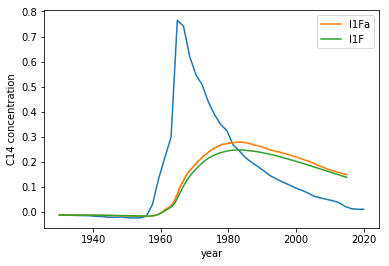

In [28]:
np.random.seed(42)
g0 = 0.1
g1 = 5.0

tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(C_atm)(tt))

np.random.seed(42)
aa_I1F, tt_I1F, CC_I1Fa = I1Fa(1930, 2015, g0, g1, N=1000, dt=0.001)
plt.plot(tt_I1F, CC_I1Fa, label = 'I1Fa')

plt.plot(*I1F(1930, 2015, g0, g1, t_eval=tt_I1F), label = 'I1F')



plt.xlabel('year')
plt.ylabel('C14 concentration')
plt.legend()

plt.show()

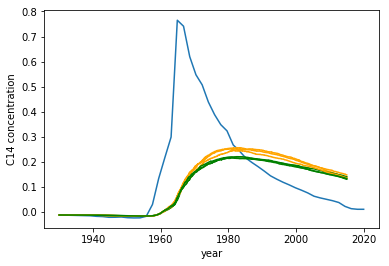

In [29]:
np.random.seed(42)
g0 = 0.1
g1 = 5.0

tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(C_atm)(tt))

np.random.seed(42)

for i in range(3):
    aa_I1F, tt_I1F, CC_I1Fa = I1Fa(1930, 2015, g0, g1, N=1000, dt=0.001)
    plt.plot(tt_I1F, CC_I1Fa, label = 'I1Fa', color='orange')

    aa_I1E, tt_I1E, CC_I1Ea = I1Ea(1930, 2015, g0, g1, N=1000, dt=0.001)
    plt.plot(tt_I1E, CC_I1Ea, label = 'I1Ea', color='green')



plt.xlabel('year')
plt.ylabel('C14 concentration')
# plt.legend()

plt.show()

# Scenario I2

2... 2 populations without interaction, one of them is quiescent

## ODE

In [30]:
I2 = c14_models.I2

In [31]:
def I2(Dbirth, Dcoll, lam, f, C_init=np.inf, t_eval=None):
    if t_eval is None:
        t_eval = [Dcoll]
    assert 0<=f<=1
    C2 = C_atm(Dbirth)
    
    tt, C1 = I1(Dbirth, Dcoll, lam, C_init=C_init, t_eval=t_eval)
    return tt, f*C1 + (1.0-f)*C2

## Compare

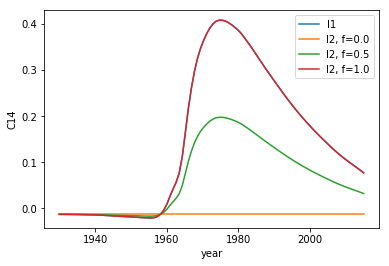

In [32]:
tt = np.linspace(1930, 2015, 100)

plt.plot(*I1(1930, 2015, 0.1, t_eval=tt), label='I1')

plt.plot(*I2(1930, 2015, 0.1, 0.0, t_eval=tt), label='I2, f=0.0')
plt.plot(*I2(1930, 2015, 0.1, 0.5, t_eval=tt), label='I2, f=0.5')
plt.plot(*I2(1930, 2015, 0.1, 1.0, t_eval=tt), label='I2, f=1.0')

plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

In [33]:
tt_I2, cc_I2 = I2(1930, 2015, 0.1, 0.5, t_eval=tt)

In [34]:
def I1b(Dbirth, Dcoll, lam, C_init=np.inf, t_eval=None):
    if t_eval is None:
        t_eval=[Dbirth, Dcoll]
    
    if C_init==np.inf:
        C_init = C_atm(Dbirth)
    
    def rhs(c, t, lam):
        return lam * (np.vectorize(C_atm)(t) - c)


    C = sp.integrate.odeint(func=rhs, 
                            y0=[C_init],
                            t=t_eval,
                            args=(lam,))
    
    return t_eval, C[:,0] #C['t'], C['y'][0]

CPU times: user 1.7 s, sys: 12.4 ms, total: 1.71 s
Wall time: 1.72 s
CPU times: user 12.3 s, sys: 11.9 ms, total: 12.3 s
Wall time: 12.3 s


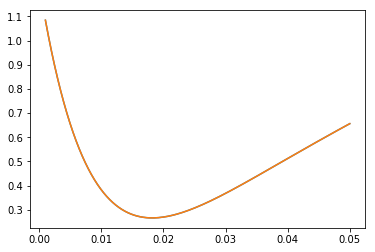

In [35]:
f = lambda lam: np.sum((cc_I2 - I1(1930, 2015, lam, t_eval=tt_I2)[1])**2)
g = lambda lam: np.sum((cc_I2 - I1b(1930, 2015, lam, t_eval=tt_I2)[1])**2)

x = np.linspace(0.001, 0.05, 200)
%time plt.plot(x, np.vectorize(f)(x))
%time plt.plot(x, np.vectorize(g)(x))
plt.show()


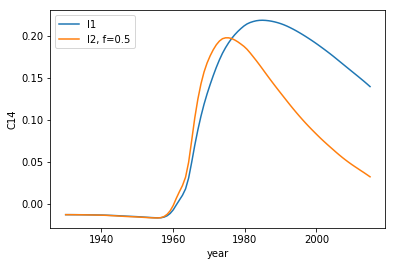

In [36]:
tt = np.linspace(1930, 2015, 100)

plt.plot(*I1(1930, 2015, lam, t_eval=tt), label='I1')

plt.plot(tt_I2, cc_I2, label='I2, f=0.5')

plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

# Scenario IX

## ODE

In [37]:
IX = c14_models.IX

## Compare

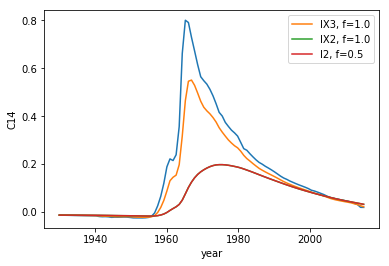

In [38]:
tt = np.linspace(1930, 2015, 100)

plt.plot(tt, np.vectorize(C_atm)(tt))
# plt.plot(*I1(1930, 2015, 0.1, t_eval=tt), label='I1')

plt.plot(*IX(1930, 2015, [0.1, 1.1], [0.1, 0.7], t_eval=tt), label='IX3, f=1.0')
plt.plot(*IX(1930, 2015, [0.1], [0.5], t_eval=tt), label='IX2, f=1.0')
plt.plot(*I2(1930, 2015, 0.1, 0.5, t_eval=tt), label='I2, f=0.5')
# plt.plot(*I2(1930, 2015, 0.1, 1.0, t_eval=tt), label='I2, f=1.0')

plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

# Scenario IL

2 populations, only first population (A) divides, only second population (B) dies, and differentation from A to B happens

## Gillespie

In [39]:
def mu(lam, f):
    return lam * f / (1-f)



/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


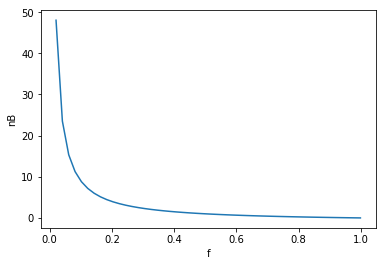

In [40]:
def nB(lam, f, nA):
    return lam / mu(lam, f) * nA

ff = np.linspace(0, 0.999)
plt.plot(ff, nB(0.1, ff, 1))
plt.xlabel('f')
plt.ylabel('nB')
plt.show()

In [41]:
@numba.njit
def ILa(Dbirth, Dcoll, lam, f, n=1000, C_init=np.inf):
    delta = lam
    nA = f * n
    nB = n - nA
    mu = lam * f / (1-f)
    
    t = Dbirth
    nB = lam / mu * nA
    
    if C_init==np.inf:
        C_init = C_atm(t)
    ccA = [C_init for i in range(nA)]
    ccB = [C_init for i in range(nB)]
    
    # Pre-allocated propensity vector, no values yet
    aa = np.empty(3)
    

    tt = list(np.empty(0))
    meancc = list(np.empty(0))
    
    
    while True:
        nA = len(ccA)
        nB = len(ccB)
        
        tt.append(t)
        meancc.append(np.mean(np.array(ccA + ccB)))
        
       
        # division
        aa[0] = lam * nA 
        # death
        aa[1] = mu * nB 
        # differentiation
        aa[2] = delta * nA
        
        t += np.random.exponential(1/aa.sum())
        
        selection_interval = np.cumsum(aa/aa.sum())
        p = np.random.rand()
        
                
        if p<selection_interval[0]:
            # cell division
            # select random cell
            i = np.random.randint(nA)
            # get C14 concentration from a random cell and delete this cell
            c = ccA.pop(i)
            # calculate new C14 concentration
            c = 0.5 * (c + C_atm(t))
            # add two new cells with updated concentration
            ccA.append(c)
            ccA.append(c)
        elif p<selection_interval[1]:
            # cell death
            # select random cell
            i = np.random.randint(nB)
            # delete it
            ccB.pop(i)
        else:
            i = np.random.randint(nA)
            ccB.append(ccA.pop(i))
            
        
        if t > Dcoll:
            break
    
    return tt, meancc


## ODE

In [42]:
IL = c14_models.IL

## Compare

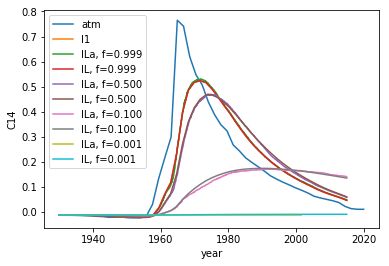

In [43]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(C_atm)(tt), label='atm')

plt.plot(*I1(1930, 2015, 0.2, t_eval=np.linspace(1930, 2015)), label='I1')

for f in [0.999, 0.5, 0.1, 0.001]:
    plt.plot(*ILa(1930, 2015, 0.2, f, n=1000), label='ILa, f={:.3f}'.format(f))
    plt.plot(*IL(1930, 2015, 0.2, f, t_eval=np.linspace(1930, 2015)), 
             label='IL, f={:.3f}'.format(f))

plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

### Fit I1 to ILa

In [44]:
tt_ILa, cc_ILa = ILa(1930, 2015, 0.1, 0.5, n=1000)

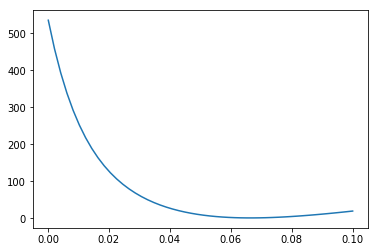

In [45]:
f = lambda lam: np.sum((cc_ILa - I1(1930, 2015, lam, t_eval=tt_ILa)[1])**2)

x = np.linspace(0.0001, 0.1, 50)
plt.plot(x, np.vectorize(f)(x))
plt.show()

In [46]:
lam = sp.optimize.minimize(f, 0.02, method='Nelder-Mead')['x']
lam

array([ 0.0664375])

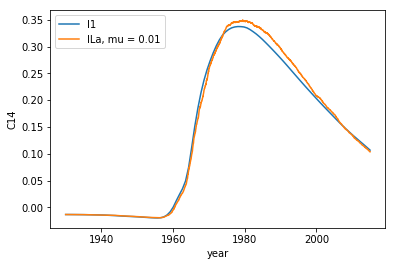

In [47]:
tt = np.linspace(1930, 2015, 100)

plt.plot(*I1(1930, 2015, lam, t_eval=tt), label='I1')

plt.plot(tt_ILa, cc_ILa, label='ILa, mu = 0.01')

plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

# Scenario IK

2 populations, only first population (A) divides, both populations (A&B) die, and differentation from A to B happens

## Gillespie

In [48]:
# @numba.njit
def IKa(Dbirth, Dcoll, lam, f, n=1000, C_init=np.inf):
    t = Dbirth
    nA0 = f * n
    nB0 = n - nA0
    mu = f * lam
    delta = (1 - f) * lam
    
    if C_init==np.inf:
        C_init = C_atm(t)
    ccA = [C_init for i in np.arange(nA0)]
    ccB = [C_init for i in np.arange(nB0)]
    
    # Pre-allocated propensity vector, no values yet
    aa = np.empty(3)
    

    tt = list(np.empty(0))
    meancc = list(np.empty(0))
    
    while True:
        nA = len(ccA)
        nB = len(ccB)
        
        tt.append(t)
        meancc.append(np.mean(np.array(ccA + ccB)))
        
       
        # division
        aa[0] = lam * nA 
        # death
        aa[1] = mu * (nA + nB)
        # differentiation
        aa[2] = delta * nA
        
        t += np.random.exponential(1/aa.sum())
        
        selection_interval = np.cumsum(aa/aa.sum())
        p = np.random.rand()
        
                
        if p<selection_interval[0]:
            # cell division
            # select random cell
            i = np.random.randint(nA)
            # get C14 concentration from a random cell and delete this cell
            c = ccA.pop(i)
            # calculate new C14 concentration
            c = 0.5 * (c + C_atm(t))
            # add two new cells with updated concentration
            ccA.append(c)
            ccA.append(c)
        elif p<selection_interval[1]:
            # cell death
            # select random cell
            i = np.random.randint(nA + nB)
            # delete it
            if i<nA:
                ccA.pop(i)
            else:
                ccB.pop(i - nA)
        else:
            i = np.random.randint(nA)
            ccB.append(ccA.pop(i))
            
        
        if t > Dcoll:
            break
    
    return tt, meancc


## Compare

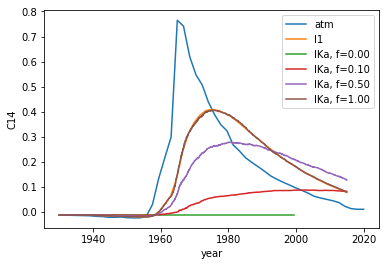

In [49]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(C_atm)(tt), label='atm')

lam = 0.1

plt.plot(*I1(1930, 2015, lam, t_eval=np.linspace(1930, 2015)), label='I1')

for f in [1e-3, 0.1, 0.5, 1.0]:
    plt.plot(*IKa(1930, 2015, lam, f, n=1000), 
         label='IKa, f={:.2f}'.format(f))


plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

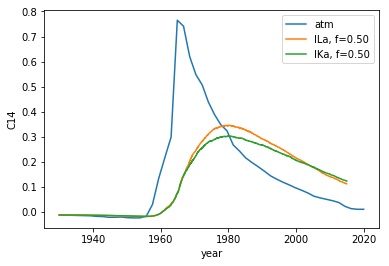

In [50]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(C_atm)(tt), label='atm')

lam = 0.1
f = 0.5

plt.plot(*ILa(1930, 2015, lam, f, n=1000), 
         label='ILa, f={:.2f}'.format(f))

plt.plot(*IKa(1930, 2015, lam, f, n=1000), 
         label='IKa, f={:.2f}'.format(f))

plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

### Fit I1 to IKa

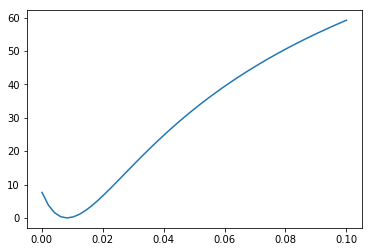

In [51]:
tt_IKa, cc_IKa = IKa(1930, 2015, 0.1, 0.1, n=1000)

f = lambda lam: np.sum((cc_IKa - I1(1930, 2015, lam, t_eval=tt_IKa)[1])**2)

x = np.linspace(0.0001, 0.1, 50)
plt.plot(x, np.vectorize(f)(x))
plt.show()

In [52]:
lam = sp.optimize.minimize(f, 0.02, method='Nelder-Mead')['x']
lam

array([ 0.0083125])

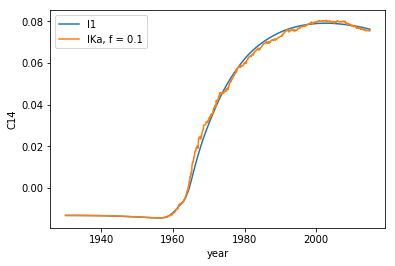

In [53]:
tt = np.linspace(1930, 2015, 100)

plt.plot(*I1(1930, 2015, lam, t_eval=tt), label='I1')

plt.plot(tt_IKa, cc_IKa, label='IKa, f = 0.1')

plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

# Scenario R1

R... Replacing dead cells with cells that have the current atmospheric C-14 concentration. That's the hypotheses for all models by Samuel Bernard
1... 1 population

## Gillespie

In [15]:
@numba.njit
def R1a_cell(Dbirth, Dcoll, r, C_init=np.inf):
    t = Dbirth
    
    if C_init==np.inf:
        C_init = C_atm(t)
    c = C_init
    
    while True:
        t += np.random.exponential(1/r)
        if t > Dcoll:
            return c
        else:
            c = C_atm(t)
    

@numba.njit
def R1a(Dbirth, Dcoll, r, N=1000, C_init=np.inf):
    cc = np.array([R1a_cell(Dbirth, Dcoll, r, C_init) for i in range(N)])
    return cc.mean()

## Bernard

In [16]:
import c14_models
%reload_ext c14_models

In [17]:
R1b = c14_models.C_scenario_A

In [18]:
R1b(1950, 2020, 0.1)

0.05121900569107425

## ODE

First moment for a master equation of Bernard's model results in the same ODE as I1

In [19]:
R1 = I1

## Compare

In [39]:
%timeit R1b(1950, 2020, 1.0)

3.21 ms ± 34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
%timeit R1(1950, 2020, 1.0, t_eval=np.linspace(1950, 2020))[-1][-1]

8.48 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


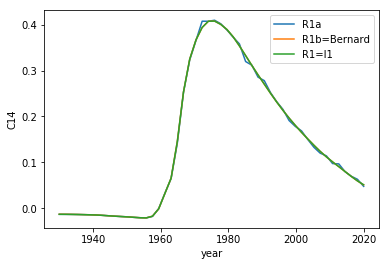

In [57]:
lam = 0.1
tt = np.linspace(0.01, 90)
Dbirth = 1930
t=90

plt.plot(Dbirth+tt, [R1a(Dbirth, Dbirth+t, lam) for t in tt], label='R1a')
plt.plot(Dbirth+tt, [R1b(Dbirth, Dbirth+t, lam) for t in tt], label='R1b=Bernard')
plt.plot(*R1(Dbirth, Dbirth+t, lam, t_eval=Dbirth+tt), label='R1=I1')

plt.legend()

plt.xlabel('year')
plt.ylabel('C14')

plt.show()

# Scenario R1E

E...Age-dependent rates

## Time-discrete implementation

In [58]:
@numba.njit
def k(a, g0, g1):
    return g0 * g1 / (g1 + a)

@numba.njit
def R1Ea(Dbirth, Dcoll, g0, g1, C_init=np.inf, N=1000, dt=0.1):
    t = Dbirth
    
    if C_init==np.inf:
        C_init = C_atm(t)
    cc = C_init * np.ones(N)
    aa = np.zeros(N)
    
    tt = np.arange(Dbirth, Dcoll, dt)
    cc_mean = np.empty_like(tt)
    
    for i, t in enumerate(tt):
        pp = k(aa, g0, g1) * dt
        
        replace = np.random.rand(N) < pp
        replace_ind = np.where(replace)[0]
        
        cc_new = C_atm(t)
        
        cc[replace_ind] = cc_new
        aa[replace_ind] = 0.0
        
        cc_mean[i] = cc.mean()
        
        aa += dt
    return aa, tt, cc_mean

## ODE

In [59]:
def R1E(Dbirth, Dcoll, g0, g1, C_init=np.inf, t_eval=None):
    if t_eval is None:
        t_eval = [Dcoll]
    if C_init==np.inf:
        C_init = C_atm(Dbirth)
        
    # in the future get analytic expression to calculate steady state age distribution 
    aa, *_ = R1Ea(Dbirth, Dcoll, g0, g1, N=1000, dt=0.001)    
    r1 = k(aa, g0, g1).mean()
    
    tt_I1, CC_I1 = I1(Dbirth, Dcoll, r1, t_eval=t_eval)
    
    return tt_I1, CC_I1

## Compare

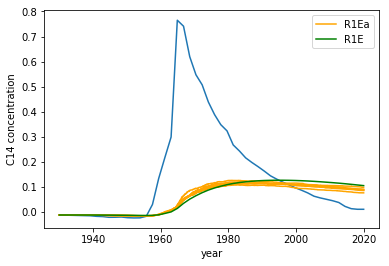

In [60]:
np.random.seed(42)
g0 = 0.1
g1 = 5.0

tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(C_atm)(tt))

for i in range(5):
    aa_R1E, tt_R1E, CC_R1Ea = R1Ea(1930, 2020, g0, g1, N=1000, dt=0.001)
    plt.plot(tt_R1E, CC_R1Ea, color='orange')

aa_R1E, tt_R1E, CC_R1Ea = R1Ea(1930, 2020, g0, g1, N=1000, dt=0.001)
plt.plot(tt_R1E, CC_R1Ea, label = 'R1Ea', color='orange')

plt.plot(*R1E(1930, 2020, g0, g1, t_eval=tt), label = 'R1E', color='green')

plt.xlabel('year')
plt.ylabel('C14 concentration')
plt.legend()

plt.show()

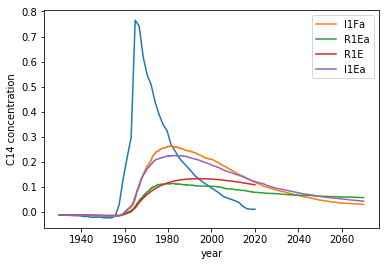

In [61]:
np.random.seed(42)
g0 = 0.1
g1 = 5.0

tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(C_atm)(tt))

aa_I1F, tt_I1F, CC_I1Fa = I1Fa(1930, 2070, g0, g1, N=1000, dt=0.001)
plt.plot(tt_I1F, CC_I1Fa, label = 'I1Fa')

aa_R1E, tt_R1E, CC_R1Ea = R1Ea(1930, 2070, g0, g1, N=1000, dt=0.001)
plt.plot(tt_R1E, CC_R1Ea, label = 'R1Ea')

plt.plot(*R1E(1930, 2020, g0, g1, t_eval=tt), label = 'R1E')

aa_I1E, tt_I1E, CC_I1Ea = I1Ea(1930, 2070, g0, g1, N=1000, dt=0.001)
plt.plot(tt_I1E, CC_I1Ea, label = 'I1Ea')



plt.xlabel('year')
plt.ylabel('C14 concentration')
plt.legend()

plt.show()

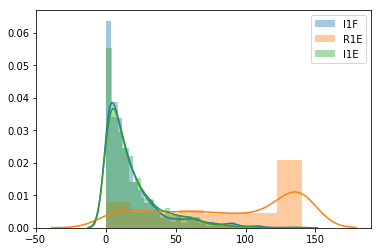

In [62]:
sns.distplot(aa_I1F, label='I1F')
sns.distplot(aa_R1E, label='R1E')
sns.distplot(aa_I1E, label='I1E')
plt.legend()
plt.show()